# Document Overview
## This file outlines the following procedures using the E-field scan data as an example:

1. Generating a blank 2D array with a size of 16 rows and 3 columns to store raw reset counts and resets per area for individual channels.
2. Filling the empty array with our specified data.
3. Saving the data array into a CSV file.

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import saq
import glob
import  csv

Welcome to JupyROOT 6.28/06


## Use the function glob() in the glob libary to obtain a list of paths matching a pathname pattern and use sorted() to sort them. Here, we use it for obtaining all root data files.

In [3]:
root_file_paths = sorted(glob.glob('/home/wwz/saq_analysis/calibration/E_scan/*.root')) #replace the path to the root files with your own one.
#sorted(root_file_paths)
#print(root_file_paths)

## For each root data file:
1. Generate a blank 2D array
2. Fill the following data into the 2D array: 
* column 1: channel numbers 1-16                              
* column 2: resets/area in each channel                           
* column 3: raw resets in each channel     
3. Save the data arrary into a csv file for each root data file                     


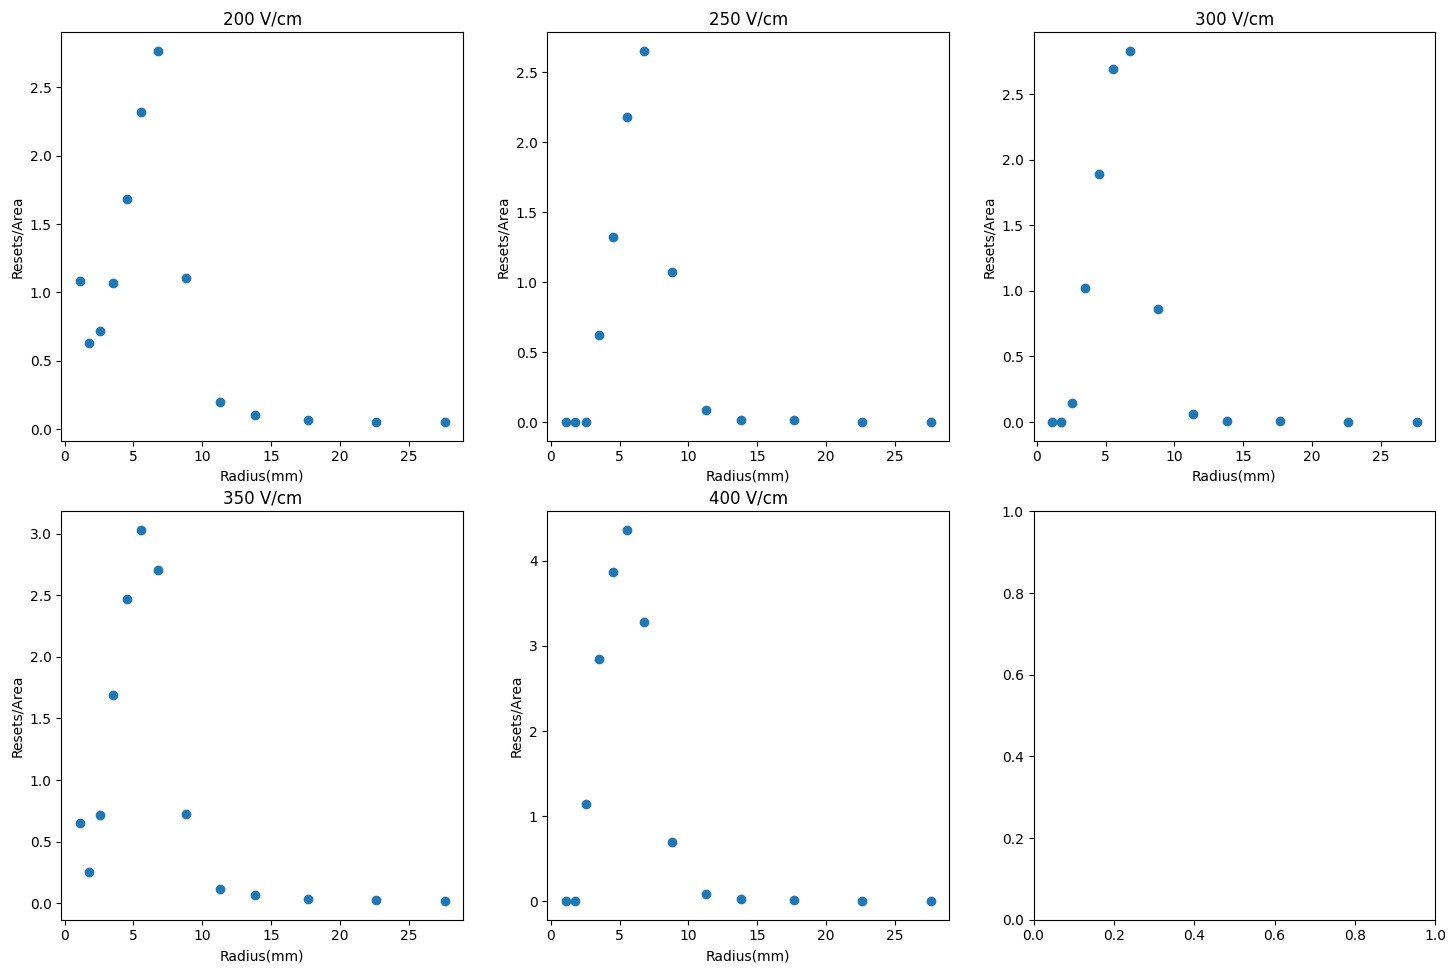

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.tight_layout(pad=3.0)

#save_data is the 2D array to store channel number (column 1), resets/area (column 2) and raw resets (column 3)
save_data = np.zeros((saq.N_SAQ_CHANNELS, 3))
save_data[:,0] = np.arange(saq.N_SAQ_CHANNELS)+1  # store channel numbers 1-16 in column 1 using the np.arrange() function

E_field =[200, 250, 300, 350, 400]
    
# Iterate through each root file
for k, root_file_path in enumerate(root_file_paths):
    file = uproot.open(root_file_path)
    #print(root_file_path)

    # Access the tree from the ROOT file
    tree = file["tt"]  # 'tt' is the name of the data tree in the root file

    # Convert the tree data into a dictionary
    data = tree.arrays(library="np")
    # Get timestamps, mask and pid from the data
    timestamps = data["Timestamp"]
    mask = data["ChMask"]
    pid = data["pid"]
    #remove fake resets with mask==0 and the resets with min. pid
    filtered_mask = [mask[i] for i in range(len(timestamps)) if mask[i] !=0 and pid[i] != min(pid)]

    #print(len(filtered_pid))
    #print(len(filtered_mask))
    
    ch_resets = [] # store all resets in 16 channels

    #put all resets corresponding to the channel number into one data array, ch_reset
    for i in range(len(filtered_mask)):
        #print(saq.channels_in_reset_mask(filtered_mask[i]))
        for j in range(len(saq.channels_in_reset_mask(filtered_mask[i]))):
            ch_resets.append(saq.channels_in_reset_mask(filtered_mask[i])[j])
    
    #print(ch_resets)
    
    # Initializing reset counts for 16 channels 
    ch = [0] * 16 #ch_single[i] stores the number of single-channel resets in channel i. 
    
    #put the resets in each channel to the individual array
    for num in ch_resets:
        ch[num] += 1
    #print (ch)

    row = k // 3
    col = k % 3
    ax = axes[row, col]
    
    #plot the resets/area vs radius 
    ax.scatter(saq.radius_of_channel[1:-2], ch[1:-2]/saq.area[1:-2]) # charge/area vs. radius with errors

    ax.set_xlabel('Radius(mm)')
    ax.set_ylabel('Resets/Area')
    ax.set_title(f'{200+50*k} V/cm')
    
    save_data[:, 1] = ch/saq.area #store resets/area in column 2
    save_data[:, 2] = ch #store raw resets after excluding the fake resets and the resets with min. pid in column 3

    #print(save_data)

    #Save data into a csv file
    header = ["SAQ_Channel_Numbers", "Resets_Averaged_by_Area", "Raw_Number_of_Resets"]
    outfile = root_file_path.replace('.root', '_data.csv') #The CSV files are stored within the root files directory
    with open(outfile, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        # write the header
        writer.writerow(header)
        # write multiple rows
        writer.writerows(save_data)